# Landscape Clustering by FFT Footprints
## Primary Notebook

Hi! This project is a personal project with a fun backstory. Have you ever been on vacation and wondered: Do I really have to travel this far, or is there a similar landscape closeer to my home delivering the same experience? Well I know this to be a really unusual question, but one that I asked myself, while on vacation all over Scotland.

This project aims to make similar "landscape types" easy to discover. Essentially the notebook creates one or more GeoTIFFs where different landscape types are colored. They are clustered by their topographic footprint.

### The topographic footprint


### Overview: 
This is the primary notebook of this repository, and the one that does the heavy work.

There are other notebooks to this repository:
- secondary_dem_retriever.ipynb -> This one connects to opentopography.org and retrieves DEM geotiffs (aka heightmaps) of parts of the earth.
- color_separator.ipynb -> This is just a little helper notebook (only rough code). This one helped creating custom color palettes for coloring the resulting images.



In [1]:
# What we might need eventually
# rasterio for geotiffs
# dask array for parallel computing of large arrays
# pyfftw for 2d fft

## Overview of the classes and their interconnection
The subject of this notebook is to cluster different landscapes across multiple DEM-GeoTIFFs. 

### GeographicBounds
This is an object that saves West, South, East, North bounds, as well as the projection, and maybe some other additional info.

### AugmentedDEM
This will be the "container" for all information regarding *one* specific DEM raster map.

### EmbeddingMap
This will be part of each AugmentedDEM. Here we will save the labels created by the clustering.




## How to make the GeoTIFF images usable by my algorithm:
It’s important to note, that the original DEM data is in arc seconds. To avoid skewed results it has to be compressed by cos(latitude) in width.  That way the metric distances (almost) resemble the distances pixel-wise

After that the images will be scaled to 1/4 (as of now), because processing becomes about 4^2 times faster.

Before processing, the data will have to be split up into quadratic tiles which are supposed to be equal in their length.

I guess we should combine the processes, namely selecting tiles of equal size and then reducing their size to a given size in pixels

In [2]:
# Imports

# Filesystem, JSON
import os
import json


# Rasterio for handling GeoTIFFs
import rasterio
from rasterio.transform import Affine
from rasterio.warp import calculate_default_transform
from rasterio.windows import from_bounds


# Resampling of the tiles
from PIL import Image 


# For interpolation of the results
from scipy.interpolate import griddata
from scipy import ndimage # for filtering
 

# Math may not be missing
import math
import numpy as np
import dask.array as da
import pyfftw 


# The heart: we use k-means-clustering
from sklearn.cluster import KMeans
import hdbscan
from sklearn.cluster import OPTICS
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN


# Regex for updating filenames
import re


# For earth related numbers
from pyproj import Geod
from pyproj import Transformer
geod = Geod(ellps="WGS84")


# Matplotlib for graphics
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap


# For timing 
import time


# For multiprocessing
from multiprocess import Pool, cpu_count

In [3]:
# Helper functions


def mode_filter(label_map, radius = 10) -> np.ndarray:
    '''
    Returns the most prevalent label in a given radius inside a label map.
    The label map has to be in shape (y,x), the label values can be arbitrary integers.
    '''
    y, x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x**2 + y**2 <= radius **2



    def mode_filter_func(values):
        counts = np.bincount(values.astype("uint8"))
        return np.argmax(counts)
    
    filtered = ndimage.generic_filter(
        label_map,
        function = mode_filter_func,
        footprint=mask,
        mode="nearest"
    )

    return filtered



def constrain_labels(input) -> list:
    '''
    Takes a list of integer labels in any range and converts them to 1, 2, 3…
    '''

    unique_labels = np.sort(np.unique(input))
    new_labels = np.arange(0,len(unique_labels), 1)
    from_to = dict(zip(unique_labels,new_labels))

    constrained_labels = np.vectorize(from_to.get)(input)

    return constrained_labels



def color_to_numpy(stringlist) -> np.ndarray:
    '''
    This converts a list of string hex color codes to actual rgb values in a numpy array.
    '''

    colorlist = np.empty((len(stringlist),3))

    for i, string in enumerate(stringlist):
        removed_hashtag = re.search(r"(?i)([a-f0-9]+)", string).group(0)
        colorlist[i] = np.array((int(removed_hashtag[0:2],16),
                        int(removed_hashtag[2:4],16),
                        int(removed_hashtag[4:6],16)))

    return colorlist



def euclidean_distance (y_a, y_b, x_a, x_b) -> float:
    '''
    Calculates the pythagorean distance between two points.
    '''

    return math.sqrt((y_a-y_b)**2 + (x_a-x_b)**2)



def threshold (input, threshold, bandwidth = 1) -> float:
    '''
    Creates smooth edges in the circle masks.
    Values below threshold become 0, values above 1.
    Values at the threshold ± half bandwidth are faded.
    '''

    # This is essentially anti aliasing without subsampling.

    result = np.interp(input, [threshold-(bandwidth/2), threshold+(bandwidth/2)], [0,1])
    return result;



def CircleImage (height, width, radius, inverted = False, bandwidth = 1) -> np.ndarray:

    '''
    Returns an antialiased image of a circle with a given radius as a numpy array for masking.
    '''

    # Height, width defines the shape of the 'image'
    # Inverted flips colors
    # The bandwidth defines the width of a smooth edge of the circle (for anti aliasing)

    circle_image = np.zeros((height, width))

    if radius == 0:
        return (1 - circle_image) if inverted else (circle_image)
    else:
        for x in range(width):
            for y in range(height):
                circle_image[y,x] = euclidean_distance(
                    y+(0.5 if height%2 == 1 else 0), height / 2,
                    x+(0.5 if width%2 == 1 else 0), width / 2
                )

    if inverted:
        return 1-threshold(circle_image, radius, 1)
    else:
        return threshold(circle_image, radius, 1)



def RingImage (height, width, inner_radius, outer_radius, bandwidth) -> np.ndarray:

    '''
    Utilizes two circles to create a ring mask with smooth edges.
    Please look into CircleImage for in-depth definition.
    '''

    if outer_radius < inner_radius:
        raise ValueError("The inner radius must be smaller than the outer radius.")

    # This combines two circles to form a ring mask
    outercircle = CircleImage(height, width, outer_radius, 
                              inverted = True, bandwidth=bandwidth)
    innercircle = CircleImage(height, width, inner_radius, 
                              inverted = True, bandwidth=bandwidth)
    
    ringimg = outercircle - innercircle

    return  (ringimg - ringimg.min()) / (ringimg.max() - ringimg.min())



def RingImageSeries(height,width,steps,bandwidth) -> np.ndarray:

    '''
    This creates a 3D numpy array of the shape
    (Masks, individual Height, individual Width)
    This is used to sum and average the FFT magnitudes
    '''

    # The diameter gets bigger logarithmically, starting with a diameter of 1
    smallest_side = min(height,width)

    outer_radii = np.logspace(0, np.log2(smallest_side / 2), steps, base=2) # 0 means it starts with 1 (log)
    inner_radii = np.append(0,outer_radii[:-1])


    all_masks = np.zeros((steps,height, width))

    for i in range(steps):
        all_masks[i] = RingImage(height,width,inner_radii[i],outer_radii[i],bandwidth=bandwidth)
            
    return all_masks



In [4]:
# Helper classes








class SimpleTimer:
    '''This class is just a timer for checking the performance'''



    def __init__(self, description):
        self.description = description
    
    def __enter__(self):
        self.timer = time.perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time_needed = time.perf_counter() - self.timer
        print(f"{self.description} took {self.time_needed:.1f} Seconds")



class VerboseInfoTimer:
    '''
    This class wraps processes to help identifying what is done by printing info about them.
    '''

    def __init__(self, process_description: str, current_index: int = 1, total_count: int = 1, single_description: str | None = None):
        self.sd = single_description
        self.pd = process_description
        self.curr_it = current_index + 1
        self.total_count = total_count
        self.rest = total_count - self.curr_it

    def __enter__(self):
        self.timer = time.perf_counter()

        if self.total_count > 1:
            if self.curr_it == 1:
                print(f"\n{self.pd} starting…\n")
            print(f"{self.sd} {self.curr_it} of {self.total_count}…")
        else:
            print(f"{self.pd} starting…")

    def __exit__(self, type, value, traceback):
        self.time_needed = time.perf_counter() - self.timer

        if self.total_count > 1:
            print(f"{self.sd} completed. This one took {self.time_needed:.1f} seconds.")

            if self.rest > 0:
                print(f"{self.rest} more to go.")
            else:
                print(f"{self.pd} ({self.total_count}) completed.")
        else:
            print(f"{self.pd} completed. It took {self.time_needed:.1f} seconds.")

        print("")

In [5]:
# Sort labels by size

def sort_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    size_order = np.argsort(-counts)

    lookup = np.empty_like(unique)
    lookup[size_order] = np.arange(len(size_order))

    relabeled = lookup[labels]
    return relabeled

<a id="settings">Anchor</a>
## Code explanation: Settings
The following section sets the parameters for the main functions. I chose dictionaries to later be able to import and export JSON configs easily. 

In general there are **internal_settings** that control the execution, as well as **temporary_data** in which the intermediary results will be stored.

The execution of the processing pipeline starts [at the end of the notebook](#execution).

In [6]:
# Settings for running this Notebook

internal_settings = {}

internal_settings["files"] = {}
internal_settings["files"]["dem_folder"] = "input_geotiffs" #Here the to-be-used-geotiffs are located

internal_settings["fft"] = {}
internal_settings["fft"]["tile_size_km"] = 10 # 10 average length and width of a tile that is processed individually
internal_settings["fft"]["tile_size_px"] = 20 # 20

internal_settings["fft"]["tile_overlap_percent"] = 85 # 85 How much (by a tile length in percent) do the tiles overlap
internal_settings["fft"]["fft_levels"] = 12  # 12

internal_settings["output"] = {}
internal_settings["output"]["folder_name"] = "output_label_images" 
internal_settings["output"]["q_factor"] = 5 # 5 Bigger Q-Factor, smaller image result, faster computation
internal_settings["output"]["label_mode_filter"] = 20  # 20 this is in arbitrary units. It will adapt to the final size, so bigger images are filtered in the same way
internal_settings["output"]["label_count"] = 10 # 10 as for now

# This one calculates the actual filter size in pixels regarding the final image
internal_settings["output"]["label_mode_filter_radius"] =  int(internal_settings["output"]["label_mode_filter"] / (internal_settings["output"]["q_factor"] / 5))
internal_settings["fft"]["tile_overlap_multi"] =  1 / (1 - (internal_settings["fft"]["tile_overlap_percent"]/100))


## Code explanation: Multiprocessing
One major step in the processing is to extract tiles of equal (metric) size from the original DEM GeoTIFF. 
As this is really processor intensive, I chose to make use of the **multiprocess** library. It really speeds things up by factor 10 to 20.

In [7]:
# Multiprocessing stuff
def init_worker(image_array, transform, tile_size):
    global shared_image_array, shared_transform, shared_tile_size
    shared_image_array, shared_transform, shared_tile_size = image_array, transform, tile_size

def resample_tile(bounds):
    global shared_image_array, shared_transform, shared_tile_size

    source_window = from_bounds(*bounds, transform=shared_transform)

    # Round the resulting window to actual pixels to be used as indices
    window_row_off_px = int(source_window.row_off)
    window_col_off_px = int(source_window.col_off)
    window_height_px = int(source_window.height)
    window_width_px = int(source_window.width)


    # Create a tile as an np array from the original raster image using the given bounds
    # First index is for different channels!
    tile = shared_image_array[:, window_row_off_px : window_row_off_px + window_height_px,
        window_col_off_px : window_col_off_px + window_width_px]
    
    tile_resampled = np.stack([
        np.array(Image.fromarray(channel).resize(
            (shared_tile_size, shared_tile_size), resample=Image.BILINEAR)) 
            for channel in tile])

    return tile_resampled

In [8]:
# Define classes specific to this project

class GeographicBounds:
    '''
    Stores coordinates for both the dem maps and also the tiles.
    '''
    
    def __init__(self, west, south, east, north):
        self.west = west
        self.north = north
        self.east = east
        self.south = south


    # Center longitude
    @property
    def center_x (self): 
        return (self.west+self.east)/2


    # Center latitude
    @property
    def center_y (self): 
        return (self.north+self.south)/2


    # Center latitude
    @property
    def center_combined (self):
        return (self.center_y, self.center_x)


    # Total height in degrees
    @property
    def height_degrees (self): 
        return (abs(self.south - self.north))


    # Total width in degrees
    @property
    def width_degrees (self): 
        return min (abs(self.east - self.west), 360 - abs(self.east - self.west));  #when getting to ±180° it should choose the shorter width # CAUTION, this might be not the final solution


    # Total height in kilometres
    @property
    def height_km (self):
        return (abs(self.south - self.north) / 360.0) * math.pi * 2.0 * geod.b / 1000.0


    # Total width of the northern edge in kilometres
    @property
    def width_north_km (self):
        return (abs(self.west - self.east) / 360.0) * math.pi * 2.0 * geod.a * math.cos( math.radians(self.north) ) / 1000.0


    # Total width of the southern edge in kilometres
    @property
    def width_south_km (self):
        return (abs(self.west - self.east) / 360.0) * math.pi * 2.0 * geod.a * math.cos( math.radians(self.south) ) / 1000.0


    # Return information about the object (for to be used in a print statement for example)
    def __str__(self):
        infostring = "Infos about the GeographicBounds (all rounded):\n"
        infostring += f"-----\n"
        infostring += f"Geographic Bounds:\n"
        infostring += f"West: {self.west:>8.2f}° \n"
        infostring += f"South: {self.south:>7.2f}° \n"
        infostring += f"East: {self.east:>8.2f}° \n"
        infostring += f"North: {self.north:>7.2f}\n"
        infostring += f"-----\n"
        infostring += f"Northern Width: {self.width_north_km:.2f} km\n"
        infostring += f"Southern Width: {self.width_south_km:.2f} km\n"
        infostring += f"Height: {self.height_km:.2f} km\n"
        infostring += f"-----\n"
        infostring += f"Center (lon E, lat N): {self.center_y:.3f}°, {self.center_x:.3f}°\n"
        infostring += "\n"
        return infostring


    def as_list(self):
        return [self.west, self.south, self.east, self.north]

    def as_list_rearranged(self):
        return [self.west, self.north, self.east, self.south]


## Code explanation: This is the core of the project

The **AugmentedDem Class** is where most of the processing takes place.
Each instance corresponds to a GeoTIFF (that can be downloaded via the seccondary notebook).

### What it stores
It stores general information that is read from the GeoTIFF file. Namely it’s bounds

In [9]:

class AugmentedDEM:
    '''
    Handles the segmentation and individual processing of each GeoTIFF (aka DEM map).
    '''
    # Settings will be handed over before the processing begins
    settings = None

    def __init__(self, dem_path):
        '''
        Load key metadata from the GeoTIFF at the specified filepath.
        '''

        
    
        # Hint: No DEM data is loaded until processing.
        with rasterio.open(dem_path) as dem_file:
            self.src_crs = dem_file.crs
            
            
            # Save the geographic WGS84 bounds in a new nested object
            dst_crs = "EPSG:4326"
            coordinate_transformer = Transformer.from_crs(self.src_crs, dst_crs)
            converted_bounds = coordinate_transformer.transform_bounds(dem_file.bounds.left,
                                                                       dem_file.bounds.bottom,
                                                                       dem_file.bounds.right,
                                                                       dem_file.bounds.top)

            self.geo_bounds = GeographicBounds(converted_bounds[0], 
                                               converted_bounds[1],
                                               converted_bounds[2],
                                               converted_bounds[3])
            
            # Save the original dimensions inside this object
            self.dem_width_px = dem_file.width
            self.dem_height_px = dem_file.height
        
        # Save the original path for later 
        self.dem_path = dem_path
        


    def _calculate_tile_bounds(self): 
        '''
        This partitions the dem map into tiles that are equal in physical length.
        It sets the tile_bounds list (bounds in degrees).
        '''
        
        # This is the multiplier that essentially defines the overlap of the tiles.
        # A multiplier of 1 is no overlap, a multiplier of 2 is an overlap of 50%
        # In the settings area the overlap is set by percent, 
        # the overlap multiplier is successively calculated from that value
        tilemulti = self.settings["fft"]["tile_overlap_multi"]

        tile_height_degrees = 360 * self.settings["fft"]["tile_size_km"] * 1000 /  (math.pi * 2.0 * geod.b)

        relative_start_y = (self.geo_bounds.height_degrees % tile_height_degrees) / 2
        absolute_start_y = (self.geo_bounds.north - relative_start_y)
        absolute_end_y = (self.geo_bounds.south + relative_start_y)
        number_tiles_y = int((self.geo_bounds.height_degrees // tile_height_degrees)*tilemulti)

        absolute_bounds_y = np.linspace(absolute_start_y, absolute_end_y, number_tiles_y + 1 )
        absolute_centers_y = np.linspace(absolute_start_y - (tile_height_degrees / 2), absolute_end_y + (tile_height_degrees / 2), number_tiles_y )


        # Here will go the longitudinal splitting. The tiles of each latitude will be split with a different tile_width_degrees for each centers_y. That is due to the fact that inside a sector of the earth’s surface is getting smaller in direction of the poles (cos). This is why this is a list of np.arrays and not a 2D np-array (as length varies for each row!)

        absolute_bounds_x = []
        self.tile_bounds = []

        
        for i, center_y in enumerate(absolute_centers_y):
            tile_width_degrees = 360 * self.settings["fft"]["tile_size_km"] * 1000 /  (math.pi * 2.0 * geod.a)  / math.cos (math.radians(center_y))
            
            relative_start_x = (self.geo_bounds.width_degrees % tile_width_degrees) / 2
            absolute_start_x = (self.geo_bounds.west + relative_start_x)
            absolute_end_x = (self.geo_bounds.east - relative_start_x)
            number_tiles_x = int((self.geo_bounds.width_degrees // tile_width_degrees)*tilemulti)

            tmp_absolute_bounds_x = np.linspace(absolute_start_x, absolute_end_x, number_tiles_x + 1 )
            tmp_absolute_centers_x = np.linspace(absolute_start_x + (tile_width_degrees / 2), absolute_end_x - (tile_width_degrees / 2), number_tiles_x)

            absolute_bounds_x.append( np.array(tmp_absolute_bounds_x) )

        
        for y in range(len(absolute_centers_y-1)):
            for x in range(len(absolute_bounds_x[y])-1):
                self.tile_bounds.append(
                    GeographicBounds(absolute_bounds_x[y][x],
                                    absolute_bounds_y[y],
                                    absolute_bounds_x[y][x+1],
                                    absolute_bounds_y[y+1]))
                
        


    def _resample_tiles_multiprocessing(self):
        '''
        This method resamples tiles from the original dem data
        to all have the same pixel dimensions.
        '''
    
        tile_size = self.settings["fft"]["tile_size_px"]

        with SimpleTimer("Multiprocessing Resample of Tiles"):
         
            
            with rasterio.open(self.dem_path) as source_image:
                full_image_array = source_image.read()
                transform = source_image.transform

            
            tile_bounds_list = [bnd.as_list_rearranged() for bnd in self.tile_bounds]

            with Pool(processes=cpu_count(),
                    initializer=init_worker,
                    initargs=(full_image_array, transform, tile_size)) as pool:
                self.tiles_resampled = np.array(pool.map(resample_tile, tile_bounds_list))
                self.tiles_resampled = np.squeeze(self.tiles_resampled, axis = 1) 
                # remove the dimension for the channels, as in DEM data there should only be one channel

               
    def dump_tiles(self):
        '''This method writes the resampled tiles to disk, for testing.'''

        for i, tile in enumerate(self.tiles_resampled):
            height = self.settings["fft"]["tile_size_px"]
            width = self.settings["fft"]["tile_size_px"]

            # Calculate pixel resolution (degrees per pixel)
            res_x = ((self.tile_bounds[i].east - self.tile_bounds[i].west) / width)
            res_y = ((self.tile_bounds[i].north - self.tile_bounds[i].south) / height)

            # Create affine transform (pixel coordinates → WGS84)
            transform = Affine.translation(self.tile_bounds[i].west, self.tile_bounds[i].south) * Affine.scale(res_x, res_y)

            filepath = f"tile_dump/{self.tile_bounds[i].west:.3f}_{self.tile_bounds[i].north:.3f}.tif"

            # Write GeoTIFF
            with rasterio.open(
                filepath,
                "w",
                driver="GTiff",
                height=height,
                width=width,
                count=1, 
                dtype=tile.dtype,
                crs="EPSG:4326", 
                transform=transform,
            ) as dst:
                dst.write(tile[np.newaxis,:])



    def _create_fft_tiles(self):
        '''
        This creates an 2D FFT magnitude map for each individual tile of the map.
        '''
        fft_input_array = pyfftw.empty_aligned((len(self.tiles_resampled),
                                                self.settings["fft"]["tile_size_px"],
                                                self.settings["fft"]["tile_size_px"]),
                                                dtype = "complex64")

        fft_output_array =  pyfftw.empty_aligned((len(self.tiles_resampled),
                                                self.settings["fft"]["tile_size_px"],
                                                self.settings["fft"]["tile_size_px"]),
                                                dtype = "complex64")

        fft_execution_plan = pyfftw.FFTW(fft_input_array,
                                        fft_output_array, axes=(1,2),
                                        direction="FFTW_FORWARD",
                                        flags=("FFTW_MEASURE",))

        fft_input_array[:] = self.tiles_resampled #Important. [:] ensures the reserved empty array is used, and no new one is created! It will not work without that special slicing.

        fft_execution_plan.execute()

        fft_magnitude_spectra_unshifted = np.log(np.abs(fft_output_array) + 1) 
        self.fft_footprint = np.fft.fftshift(fft_magnitude_spectra_unshifted, axes=(1,2)) #Centered FFT



    def _split_and_average_fft_tiles(self):
        '''
        This splits the FFT magnitude map for each tile into parts that average in a given distance.
        This is essentially the "FFT Footprint".
        The result will be a numpy array in the shape of (number_of_tiles, number_of_fft_levels)
        '''

        # Set up Dask Arrays for faster computation of the weighted averages


        # The general dimensions are:
        # 1. Number of tiles (total)
        # 2. Height of a tile
        # 3. Width of a tile
        # 4. Number of levels (circle filters)

        # To multiply and divide all the dimensions have to be in the same order for all arrays

        # Weights – here go the circles
        # Weights are still (#4, #2, #3), change them to #2, #3, #4


        with SimpleTimer("Creating the weighted averages per mask"):
            
            da_weights = da.from_array(
                # The height becomes axis 0, width becomes axis 1, and different masks become axis 2
                np.transpose(temporary_data["circle_masks"],(1,2,0)) 
            )

            # First dimension (#1) is missing, add it 
            # Just a note: the tiles themselves are not x-y adressed, but the get a continuous index (1D)
            da_weights = da_weights[np.newaxis, ...]
            # Now the form of the weights is (#1, #2, #3, #4) like explained above

            # Take the results of the fft and place them also in a dask array
            # of the wanted form (see above) 
            da_magnitude_spectra = da.from_array(self.fft_footprint)[...,np.newaxis]

            # Sum the values of the areas covered by the circles, to later have something to divide by
            # to generate weighted sums
            da_weights_sum = da.sum(da_weights, axis=(1,2)) 

            # Sum the results of the FFTs multiplied by the weights of the different levels (circle filters)
            da_sum_of_spectra = da.sum(da_magnitude_spectra * da_weights, axis=(1, 2))

            # Calculate the weighted average 
            da_weighted_averages = da_sum_of_spectra / da_weights_sum

            # The result is now in the shape of #1, #4 -> Number of Tiles, Number of Levels
            self.fft_magnitude_all_levels = da_weighted_averages.compute() 

    
    def create_image(self):
        '''
        This method creates a colored image. 
        After the clustering has taken place the found labels will be translated to colors for each pixel.
        '''

        # Each tile has gotten a label
        # We know the center of each tile
        # That way we can interpolate an image by combining the two data sources
        # Remember the tiles are not in a strict raster, because they become taller
        # the closer they get to the equator.

        tmp_tile_positions = [tile.center_combined for tile in self.tile_bounds]
        tmp_pic_width = self.dem_width_px // self.settings["output"]["q_factor"]
        tmp_pic_height = self.dem_height_px // self.settings["output"]["q_factor"]

        tmp_grid_res_y = np.linspace(self.geo_bounds.north, self.geo_bounds.south, tmp_pic_height )
        tmp_grid_res_x = np.linspace(self.geo_bounds.west, self.geo_bounds.east, tmp_pic_width )

        tmp_grid_y, tmp_grid_x = np.meshgrid(tmp_grid_res_y, tmp_grid_res_x, indexing="ij")

        tmp_interpolated = griddata(tmp_tile_positions,
        self.labels, (tmp_grid_y, tmp_grid_x), method='nearest') 


        with SimpleTimer("Filtering of the mapped labels"):
            tmp_interpolated = mode_filter(tmp_interpolated, self.settings["output"]["label_mode_filter_radius"])



        # Start creating the image
   
        # I create my own color mapping for I like those colors
        custom_colors_str = ["#053608" ,
                            "#bdf2e6" ,
                            "#1c5532" ,
                            "#62f8ee" ,
                            "#ffba20" ,
                            "#2c7eb5" ,
                            "#b9c5d6" ,
                            "#404383" ,
                            "#91f88f" ,
                            "#759d7c" ,
                            "#9395a3"  
        ]

        # The image becomes colors mapped from the custom colors indexed by the constrained labels
        tmp_labels_image_rgb = color_to_numpy(custom_colors_str)[constrain_labels(tmp_interpolated)]
        self.image_rgb = (np.transpose(tmp_labels_image_rgb, (2,0,1))).astype("uint8")


    def write_image(self):
        '''Writes the created image to the disk.'''

        tmp_pic_width = self.dem_width_px // self.settings["output"]["q_factor"]
        tmp_pic_height = self.dem_height_px // self.settings["output"]["q_factor"]

        # Calculate pixel resolution for the GeoTIFF output image (degrees per pixel)
        res_x = ((self.geo_bounds.east - self.geo_bounds.west) / tmp_pic_width)
        res_y = ((self.geo_bounds.south - self.geo_bounds.north) / tmp_pic_height)

        # Create affine transform (pixel coordinates → WGS84)
        transform = Affine.translation(self.geo_bounds.west,
                                    self.geo_bounds.north) * Affine.scale(res_x, res_y)

        # I put together a comprehensive (very long) filename to recall settings later
        filename_string = os.path.basename(self.dem_path) + \
        f"tlszkm {self.settings["fft"]["tile_size_km"]:.1f}  " + \
        f"tlszpx {self.settings["fft"]["tile_size_px"]:.0f}  " + \
        f"fftlvls {self.settings["fft"]["fft_levels"]:.0f}  " + \
        f"qfctr {self.settings["output"]["q_factor"]:.0f}  " + \
        f"{self.settings["fft"]["tile_overlap_multi"]:.1f}x"+ \
        f"-ovrlp-pct {self.settings["fft"]["tile_overlap_percent"]:.0f} "+ \
        f"fltrrds {self.settings["output"]["label_mode_filter_radius"]:.0f}"+ \
        f"lblct {self.settings["output"]["label_count"]:.0f}"+ \
        f".tif"

        filepath = os.path.join(self.settings["output"]["folder_name"], filename_string)

        # Write GeoTIFF
        with rasterio.open(
            filepath,
            "w",
            driver="GTiff",
            height=tmp_pic_height,
            width=tmp_pic_width,
            count=3, 
            dtype="uint8",
            crs="EPSG:4326", 
            transform=transform,
        ) as dst:
            dst.write(self.image_rgb[0],1)
            dst.write(self.image_rgb[1],2)
            dst.write(self.image_rgb[2],3)


    def process_dem(self):
        '''
        This method runs all the necessary steps of the processing, 
        except for clustering and creating the image.
        Remember: Clustering has to be done across all loaded DEM maps
        to create comparable clusters.
        '''

        # If we did that per DEM map and not globally, we would still get clusters
        # However they would not correspond to the clusters in the other DEM maps. 

        self._calculate_tile_bounds()

        self._resample_tiles_multiprocessing()

        with SimpleTimer("Creating FFT footprints"):
            self._create_fft_tiles()

        self._split_and_average_fft_tiles()


        # Hereafter the clustering takes place (global via class method)
        # After that each colored label map is written to the disk.

    @classmethod
    def create_labels(cls, instances):
        '''
        Create one long numpy array from all the tile’s labels of every given dem map.
        '''
         
        all_magnitudes_np = np.concatenate([d.fft_magnitude_all_levels for d in instances], axis = 0)

        # Normalize across all DEMs
        all_magnitudes_np = (all_magnitudes_np - np.median(all_magnitudes_np, axis=0, keepdims=True)) / np.std(all_magnitudes_np, axis=0, keepdims=True)

        # Store the original sizes to late split the labels again
        original_tile_count = [d.fft_magnitude_all_levels.shape[0] for d in instances]
        original_indices_for_splitting =  np.cumsum(original_tile_count[:-1])

        # Clustering section
        n_clusters = cls.settings["output"]["label_count"]
        k_means_clusterer = KMeans(n_clusters = n_clusters, random_state=550)


        with SimpleTimer("Clustering"):
                all_magnitudes_np = np.nan_to_num(all_magnitudes_np, nan = 0)
                all_dem_labels = k_means_clusterer.fit_predict(all_magnitudes_np)

        with SimpleTimer("Relabeling Cluster IDs by size"):
                all_dem_labels = sort_labels(all_dem_labels)

        # Distribute the results back to the augmented dem objects
        single_dem_lables = np.split(all_dem_labels, original_indices_for_splitting) 

        for i, labels in enumerate(single_dem_lables):
            instances[i].labels = labels
        

<a id="execution">Anchor</a>

## Code explanation: Processing pipeline

The following cell executes all of the processing.
Settings are set at the [top of the notebook](#settings)

In [10]:
# Let the processing begin
temporary_data = {}
temporary_data["augmented_dems"] = []


# Assign the settings to the class variable of AugmentedDem
AugmentedDEM.settings = internal_settings

# Create objects (AugmentedDem) for all .tif-Files inside the dem_folder
with os.scandir(internal_settings["files"]["dem_folder"]) as dirlist:
    temporary_data["augmented_dems"] =[AugmentedDEM(d.path) 
                                           for d in dirlist if re.search(r"\.tif$",d.name)]
    

# Set up the masks for the weighted average
with VerboseInfoTimer("Creating the ring masks"):
    temporary_data["circle_masks"] = RingImageSeries(internal_settings["fft"]["tile_size_px"],
                                                        internal_settings["fft"]["tile_size_px"],
                                                        internal_settings["fft"]["fft_levels"],
                                                        bandwidth = 1)


for i, d in enumerate(temporary_data["augmented_dems"]):
    with VerboseInfoTimer("Processing of all DEM maps", 
                       current_index = i, 
                       total_count = len(temporary_data["augmented_dems"]),
                       single_description = "Processing DEM map"):
        d.process_dem()


# Create_labels(temporary_data["augmented_dems"], internal_settings)
with VerboseInfoTimer("Clustering and creating labels for all DEM maps"):
    AugmentedDEM.create_labels(temporary_data["augmented_dems"])


for i, d in enumerate(temporary_data["augmented_dems"]):
    with VerboseInfoTimer("Creating labeled images for all regions", 
                       current_index = i, 
                       total_count = len(temporary_data["augmented_dems"]),
                       single_description = "Creating labeled image"):
        d.create_image()
        d.write_image()

Creating the ring masks starting…
Creating the ring masks completed. It took 0.0 seconds.


Processing of all DEM maps starting…

Processing DEM map 1 of 4…
Multiprocessing Resample of Tiles took 31.4 Seconds
Creating FFT footprints took 1.9 Seconds
Creating the weighted averages per mask took 5.8 Seconds
Processing DEM map completed. This one took 39.6 seconds.
3 more to go.

Processing DEM map 2 of 4…
Multiprocessing Resample of Tiles took 9.2 Seconds
Creating FFT footprints took 0.5 Seconds
Creating the weighted averages per mask took 0.7 Seconds
Processing DEM map completed. This one took 10.5 seconds.
2 more to go.

Processing DEM map 3 of 4…
Multiprocessing Resample of Tiles took 24.2 Seconds
Creating FFT footprints took 1.3 Seconds
Creating the weighted averages per mask took 2.5 Seconds
Processing DEM map completed. This one took 28.3 seconds.
1 more to go.

Processing DEM map 4 of 4…
Multiprocessing Resample of Tiles took 5.4 Seconds
Creating FFT footprints took 0.4 Seconds
Cr

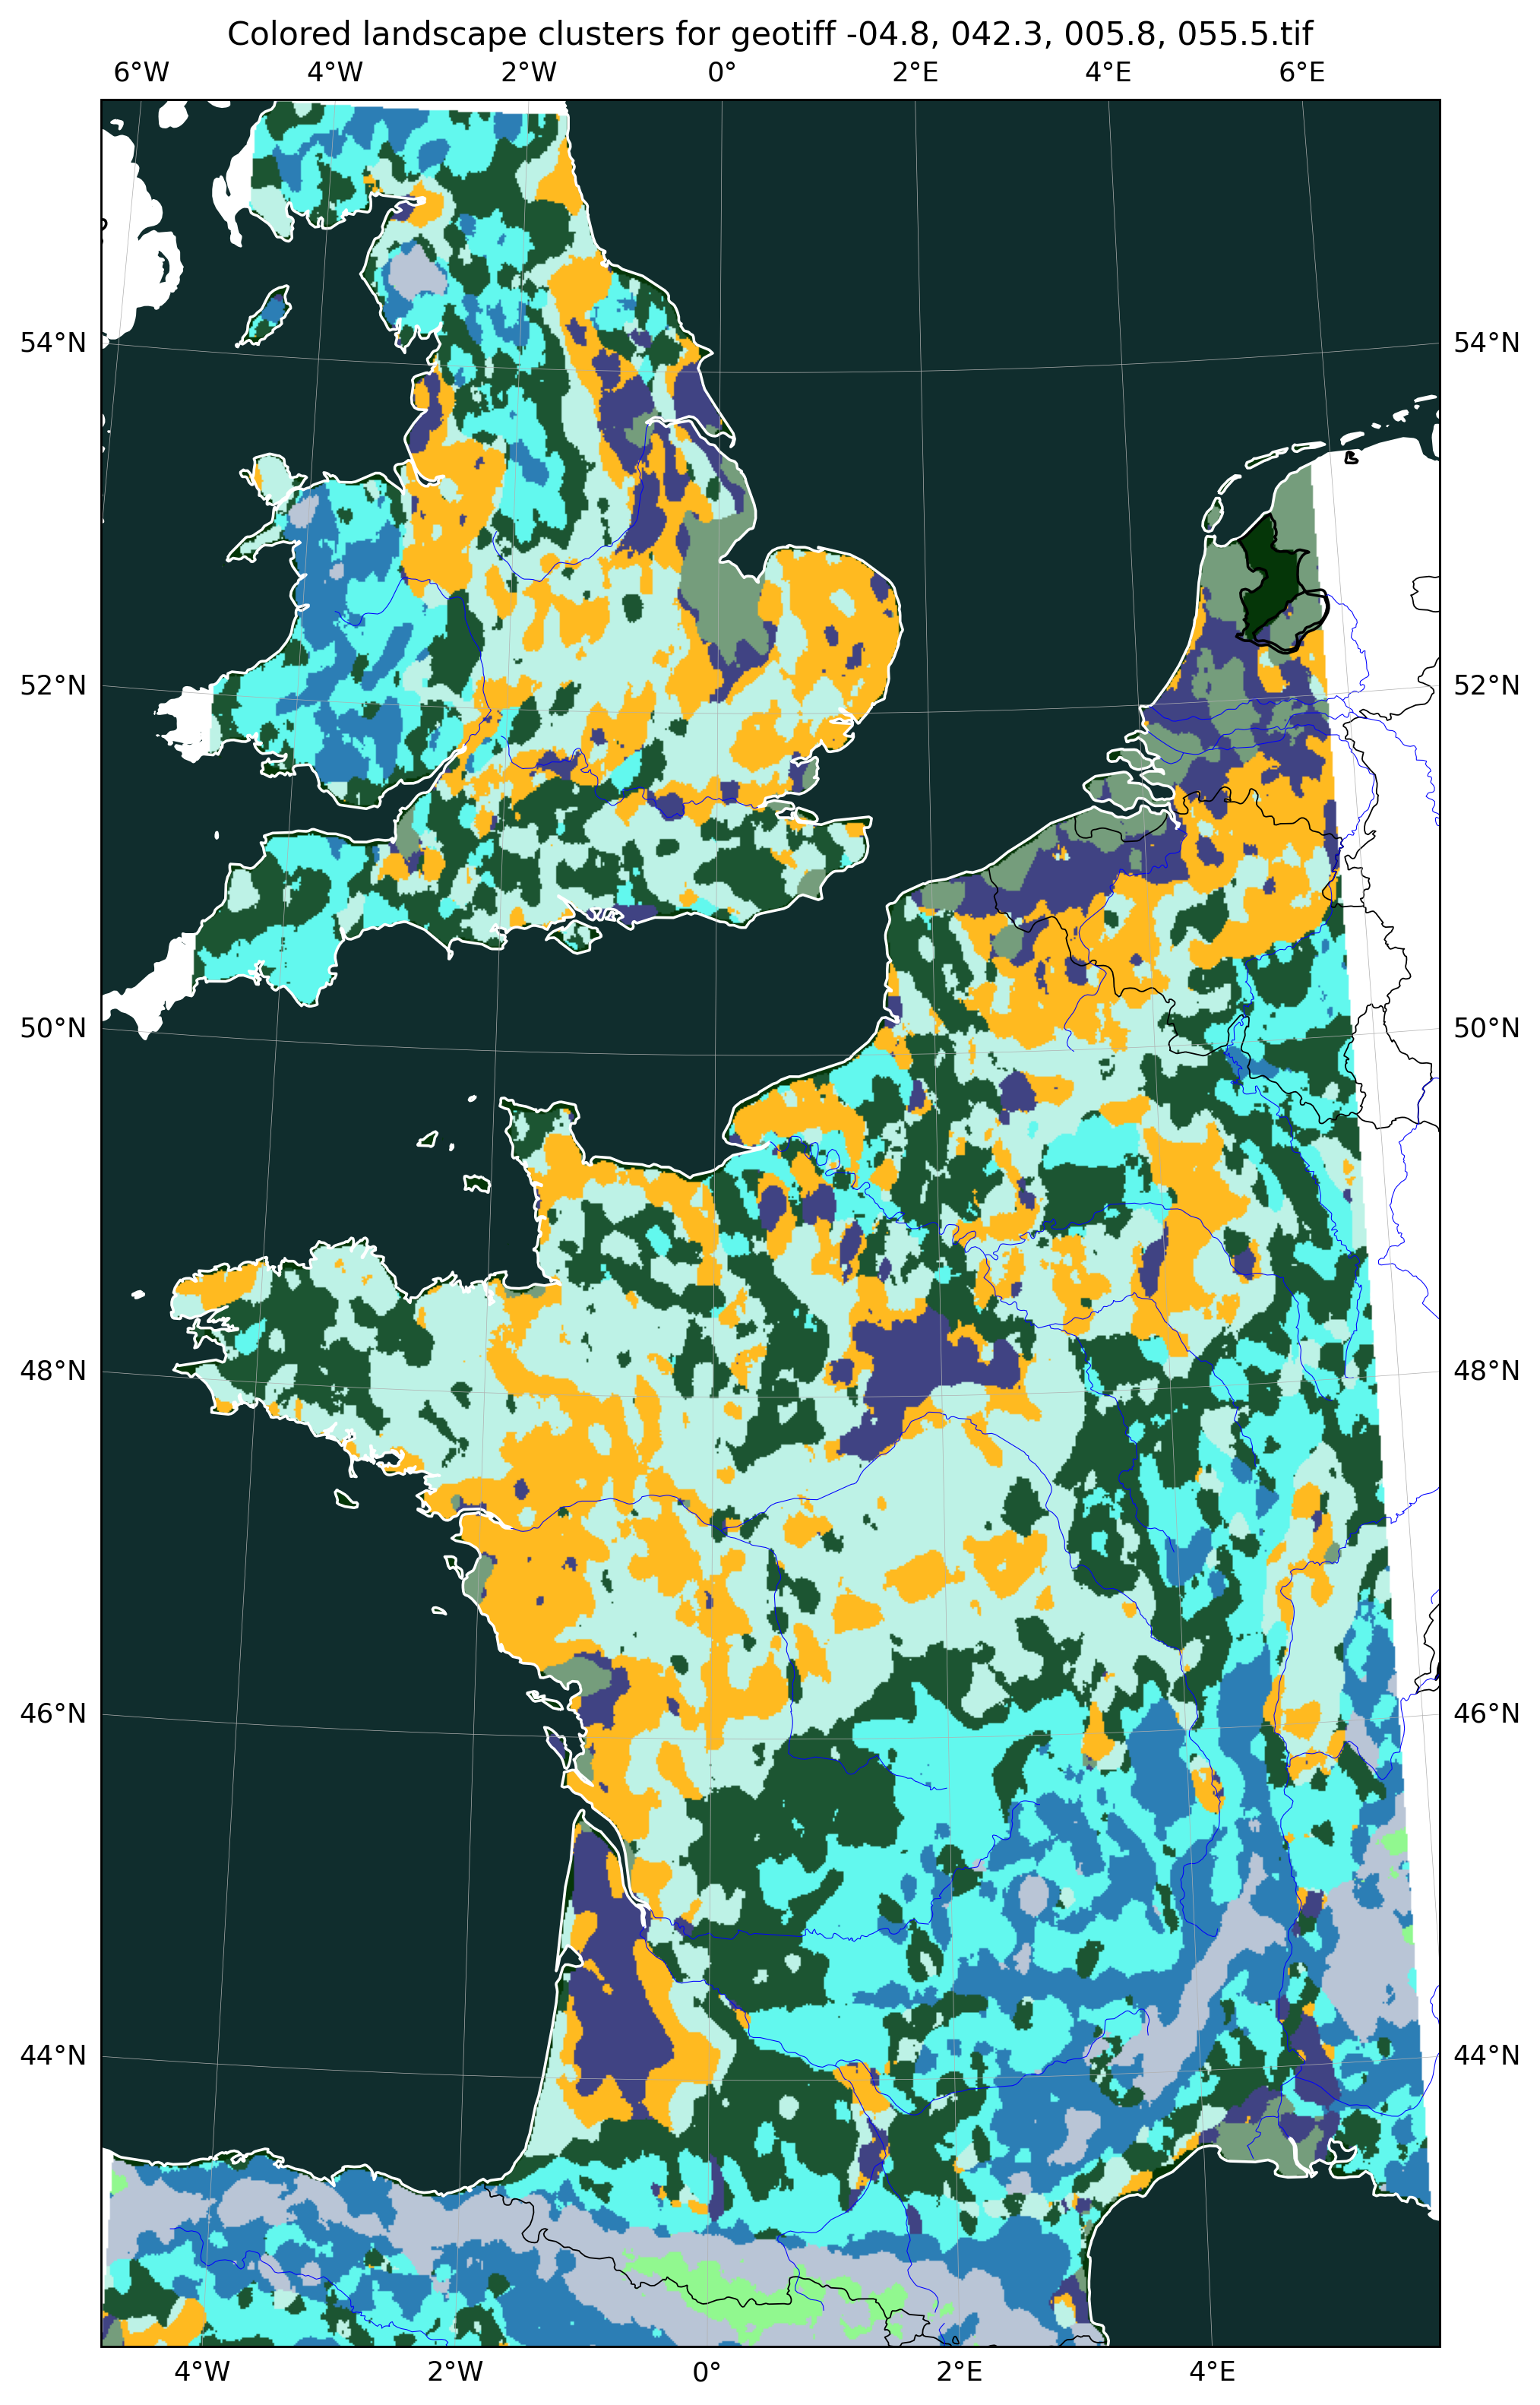

In [11]:
# Testing
import cartopy.crs as ccrs
import cartopy.feature as cfeature

current_augmented_dem = temporary_data["augmented_dems"][0]
image = np.transpose(current_augmented_dem.image_rgb,[1,2,0])

west, south, east, north = current_augmented_dem.geo_bounds.as_list()
extent = (west, east, south, north)

# Start plotting
fig = plt.figure(figsize=(10, 15), dpi=256)
ax = plt.axes(projection=ccrs.Orthographic(central_longitude=current_augmented_dem.geo_bounds.center_x, central_latitude=current_augmented_dem.geo_bounds.center_y))

ax.set_extent(extent)

# Add features
ax.add_feature(cfeature.BORDERS, edgecolor = "black", linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor = "white", linewidth=1.0)
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='blue', linewidth=0.3)
ax.add_feature(cfeature.OCEAN, zorder=1, facecolor='#102d2d')

# Plot image (projecting from PlateCarree, which assumes lat/lon coordinates)
ax.imshow(image, origin='upper', extent=extent, transform=ccrs.PlateCarree())

# Optionally, add gridlines
ax.gridlines(draw_labels=True, linewidth=0.2)

# Show
plt.title(f"Colored landscape clusters for {os.path.basename(current_augmented_dem.dem_path)}")
plt.show()